<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3



### <center> Автор материала: Романова Анастасия (Slack: @anastasiaromane)
## <center> Индивидуальный проект по анализу данных </center> 
### <center> Прогнозирование посещаемости в национальных парках и др. достопримечательностях США </center>

**План исследования**
 - Часть 1. Описание набора данных и признаков
 - Часть 2-3. Первичный и визуальный анализ признаков
 - Часть 4. Закономерности, "инсайты", особенности данных
 - Часть 5-6. Выбор метрики и модели
 - Часть 7-8. Предобработка данных и создание новых признаков и описание этого процесса
 - Часть 9. Кросс-валидация, подбор параметров
 - Часть 10. Построение кривых валидации и обучения 
 - Часть 11. Прогноз для тестовой или отложенной выборки. Оценка модели с описанием выбранной метрики
 - Часть 12. Выводы

###  Импорт библиотек

In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, validation_curve, learning_curve
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

###  Часть 1. Описание набора данных и признаков

#### Задача

Задача данного проекта - предсказать количество посетителей в национальных парках и других достопримечательностях США для последнего доступного года в датасете. Будем рещать задачу регрессии.


#### Данные

Данные взяты с этого [сайта](https://data.world/inform8n/us-national-parks-visitation-1904-2016-with-boundaries). Датасет включает в себя исторические данные о посещаемости национальных парков и достопримечательной США с 1904 по 2016 год.

#### Признаки

Загрузим наш основной датасет.

In [2]:
PATH_TO_DATA = ('data')
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'national-parks-visitation.csv'))

In [3]:
df.shape

(21560, 18)

In [4]:
df.head(2)

,Created By,Measure Selector,Year,Date Edit,ScrapeURL,GIS Notes,Gnis Id,Geometry,Metadata,Number of Records,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,YearRaw
0,Legacy,1,1/1/1904 12:00:00 AM,4/22/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,LEGACY: contact allen_mccoy@nps.gov for additi...,1163670,POLYGON,NaN,1,Crater Lake,PW,OR,CRLA,Crater Lake National Park,National Park,1500.0,1904
1,Legacy,1,1/1/1941 12:00:00 AM,4/22/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,LEGACY: contact allen_mccoy@nps.gov for additi...,1531834,MULTIPOLYGON,NaN,1,Lake Roosevelt,PW,WA,LARO,Lake Roosevelt National Recreation Area,National Recreation Area,0.0,1941


Полный датасет состоит из 21560 объектов и 18 признаков.

- **Created By** - метаданные датасета
- **Measure Selector** - метаданные датасета
- **Year** - год в формате даты
- **Date Edit** - метаданные датасета
- **ScrapeURL** - метаданные датасета
- **GIS Notes** - метаданные датасета
- **Gnis Id** - id достопримечатльности из базы данных Geographic Names Information System 
- **Geometry** - геометрическая форма парка
- **Metadata** - метаданные датасета
- **Number of Records** - метаданные датасета
- **Parkname** - название достопримечатльности (colloquial)
- **Region** - район в системе национальных парков США (подробнее [здесь](https://en.wikipedia.org/wiki/Organization_of_the_National_Park_Service )) 
- **State** - штат, где расположена достопримечатльность
- **Unit Code** - уникальный код достопримечатльности
- **Unit Name** - полное название достопримечатльности
- **Unit Type** - тип достопримечатльности
- **Visitors** - метаданные датасета (**Целевой признак**)
- **YearRaw** - год в формате текста

Загрузим дополнительный датасет, чтобы по GNIS ID вытащить широту и долготу объектов. Данный датасет взят с этого [сайта](https://geonames.usgs.gov/domestic/download_data.htm).

In [5]:
gnis_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'gnis-april2018.txt'), sep='|').rename(columns={'FEATURE_ID':'Gnis Id'})

In [6]:
gnis_df.head(3)

,Gnis Id,FEATURE_NAME,FEATURE_CLASS,STATE_ALPHA,STATE_NUMERIC,COUNTY_NAME,COUNTY_NUMERIC,PRIMARY_LAT_DMS,PRIM_LONG_DMS,PRIM_LAT_DEC,PRIM_LONG_DEC,SOURCE_LAT_DMS,SOURCE_LONG_DMS,SOURCE_LAT_DEC,SOURCE_LONG_DEC,ELEV_IN_M,ELEV_IN_FT,MAP_NAME,DATE_CREATED,DATE_EDITED
0,0,Bruceville Cemetery,Cemetery,CO,8,Boulder,13.0,400058N,1051226W,40.016099,-105.207171,NaN,NaN,NaN,NaN,1598.0,5243.0,Niwot,05/04/2015,10/22/2015
1,399,Agua Sal Creek,Stream,AZ,4,Apache,1.0,362740N,1092842W,36.461112,-109.478439,362053N,1090915W,36.348058,-109.154266,1645.0,5397.0,Fire Dance Mesa,02/08/1980,NaN
2,400,Agua Sal Wash,Valley,AZ,4,Apache,1.0,363246N,1093103W,36.546112,-109.517607,362740N,1092842W,36.461112,-109.478439,1597.0,5239.0,Little Round Rock,02/08/1980,NaN


Удалим ненужные колонки, преобразуем GNIS ID в текстовый формат и объединим два датасета по GNIS ID.

In [7]:
gnis_df.drop(['FEATURE_NAME', 'FEATURE_CLASS', 'STATE_ALPHA','STATE_NUMERIC',
              'COUNTY_NAME', 'COUNTY_NUMERIC', 'PRIMARY_LAT_DMS','PRIM_LONG_DMS',
              'SOURCE_LAT_DMS', 'SOURCE_LONG_DMS', 'SOURCE_LAT_DEC','SOURCE_LONG_DEC',
              'ELEV_IN_M','ELEV_IN_FT', 'MAP_NAME', 'DATE_CREATED','DATE_EDITED'], axis=1, inplace=True)

In [8]:
gnis_df['Gnis Id'] = gnis_df['Gnis Id'].astype('str')

In [9]:
df = pd.merge(df, gnis_df, how='left', on='Gnis Id')

###  Часть 2-3. Первичный + визуальный анализ признаков

Посмотрим на тип признаков в главном датасете.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21560 entries, 0 to 21559
Data columns (total 20 columns):
Created By           21560 non-null object
Measure Selector     21560 non-null int64
Year                 21560 non-null object
Date Edit            21560 non-null object
ScrapeURL            21560 non-null object
GIS Notes            21560 non-null object
Gnis Id              21560 non-null object
Geometry             21560 non-null object
Metadata             18848 non-null object
Number of Records    21560 non-null int64
Parkname             19342 non-null object
Region               21560 non-null object
State                21560 non-null object
Unit Code            21560 non-null object
Unit Name            21560 non-null object
Unit Type            21560 non-null object
Visitors             21556 non-null float64
YearRaw              21560 non-null object
PRIM_LAT_DEC         21558 non-null float64
PRIM_LONG_DEC        21558 non-null float64
dtypes: float64(3), int64(2), 

Из 18 признаков только 4 вещественных, включая целевой признак Visitors, все остальные категориальные или текстовые.
Посмотрим еще раз на данные.

In [11]:
df.head(3)

,Created By,Measure Selector,Year,Date Edit,ScrapeURL,GIS Notes,Gnis Id,Geometry,Metadata,Number of Records,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,YearRaw,PRIM_LAT_DEC,PRIM_LONG_DEC
0,Legacy,1,1/1/1904 12:00:00 AM,4/22/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,LEGACY: contact allen_mccoy@nps.gov for additi...,1163670,POLYGON,NaN,1,Crater Lake,PW,OR,CRLA,Crater Lake National Park,National Park,1500.0,1904,42.941064,-122.132749
1,Legacy,1,1/1/1941 12:00:00 AM,4/22/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,LEGACY: contact allen_mccoy@nps.gov for additi...,1531834,MULTIPOLYGON,NaN,1,Lake Roosevelt,PW,WA,LARO,Lake Roosevelt National Recreation Area,National Recreation Area,0.0,1941,47.911637,-118.715154
2,Legacy,1,1/1/1961 12:00:00 AM,4/22/2015,https://irma.nps.gov/Stats/SSRSReports/Park%20...,LEGACY: contact allen_mccoy@nps.gov for additi...,2055170,MULTIPOLYGON,NaN,1,Lewis and Clark,PW,WA,LEWI,Lewis and Clark National Historical Park,National Historical Park,69000.0,1961,46.286183,-124.067632


Первым делом необходимо удалить некоторые признаки из датасета, так как большинство из них являются метаданными датасета и не несут большой информативности для анализа. Кроме того, удалим признак Year в формате даты, так как нам будет достатотчно признака YearRaw.

In [12]:
df.drop(['Created By', 'Measure Selector', 'Year','Date Edit', 'ScrapeURL',
       'GIS Notes', 'Geometry', 'Metadata', 'Number of Records'], axis=1, inplace=True)

Проверим данные на пропуски.

In [13]:
df.isnull().sum()

Gnis Id             0
Parkname         2218
Region              0
State               0
Unit Code           0
Unit Name           0
Unit Type           0
Visitors            4
YearRaw             0
PRIM_LAT_DEC        2
PRIM_LONG_DEC       2
dtype: int64

4 признака имеют пропуски. Для каждого из признаков разные решения. Например, для признака Parkname можно заменить пропуски на Unknown. На самом деле, этот признак можно удалить (Сделаем это чуть позднее), т.к. есть другой более точной признак, который содержит в себе полное название достопримечательни Unit Name и не содержит пропусков.

In [14]:
df['Parkname'].fillna('Unknown', inplace=True)

Посмотрим на другие пропуски в датасете.

In [15]:
df[df.isnull().any(axis=1)]

,Gnis Id,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,YearRaw,PRIM_LAT_DEC,PRIM_LONG_DEC
300,2767391,Honouliuli,PW,HI,HONO,Honouliuli National Monument,National Monument,NaN,Total,21.388175,-158.057499
308,2766708,Minidoka,PW,WA,MIIN,Minidoka National Historic Site,National Historic Site,NaN,Total,42.681043,-114.247375
337,2035517,Valles Caldera,IM,NM,VALL,Valles Caldera National Preserve,Valles Caldera National Preserve,NaN,Total,35.916783,-106.519572
369,2766905,Pullman,MW,IL,PULL,Pullman National Monument,National Monument,NaN,Total,41.694291,-87.608798
371,need ID,Belmont-Paul Women's Equality,NC,DC,BEPA,Belmont-Paul Women's Equality National Monument,National Monument,2704.0,2016,NaN,NaN
753,need ID,Belmont-Paul Women's Equality,NC,DC,BEPA,Belmont-Paul Women's Equality National Monument,National Monument,2704.0,Total,NaN,NaN


У двух объектов отсутсвует широта и долгота. Проблема в том, что эти два объекта не имеют GNIS ID, по которому мы находили географические данные. В таком случае можно поискать долготу и широту в интернете и заменить их в датасете вручную.

In [16]:
df['PRIM_LAT_DEC'] = df['PRIM_LAT_DEC'].replace(float('nan'), 38.892235)

In [17]:
df['PRIM_LONG_DEC'] = df['PRIM_LONG_DEC'].replace(float('nan'), -77.003689)

Еще есть пропуски в целевой переменной Visitors. YearRaw у данных объектов тоже весьма странный - Total. Посмотрим на YearRaw.

In [18]:
df['YearRaw'].value_counts().head()

Total    386
2016     379
2015     375
2013     373
2014     373
Name: YearRaw, dtype: int64

In [19]:
df.loc[df['YearRaw'] == 'Total'].head()

,Gnis Id,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,YearRaw,PRIM_LAT_DEC,PRIM_LONG_DEC
300,2767391,Honouliuli,PW,HI,HONO,Honouliuli National Monument,National Monument,NaN,Total,21.388175,-158.057499
308,2766708,Minidoka,PW,WA,MIIN,Minidoka National Historic Site,National Historic Site,NaN,Total,42.681043,-114.247375
337,2035517,Valles Caldera,IM,NM,VALL,Valles Caldera National Preserve,Valles Caldera National Preserve,NaN,Total,35.916783,-106.519572
369,2766905,Pullman,MW,IL,PULL,Pullman National Monument,National Monument,NaN,Total,41.694291,-87.608798
386,1163670,Crater Lake,PW,OR,CRLA,Crater Lake National Park,National Park,34669486.0,Total,42.941064,-122.132749


386 объектов имеют Total вместо года. Предполагается, что данные объекты были созданы в результате ошибки во время сбора данных. Предлагается удалить эти объекты.

In [20]:
df = df.loc[df['YearRaw'] != 'Total']

Изменим формат целевой переменой Visitors и признака YearRaw.

In [21]:
df['YearRaw'] = df['YearRaw'].astype('int64')
df['Visitors'] = df['Visitors'].astype('int64')

Кроме того, для удобства переименуем YearRaw в Year.

In [22]:
df.rename(columns={'YearRaw': 'Year'}, inplace=True)

Т.к. наша задача предсказать количество посетителей по историческим данных, большое количество исторических данных может затруднить задачу, в связи с чем облегчим себе задачу и оставим данные, начиная с 2000 года.

In [23]:
df = df.loc[df['Year'] >= 2000]

### test и train

Теперь можно разбить данных не обучающую и тестовую выборки. Посмотрим, какой год последний в датасете.

In [24]:
np.sort(pd.unique(df['Year']))

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016])

Будем предсказывать посетителей для 2016 года по данным с 2000 по 2015.

In [25]:
train = df.loc[df['Year'] != 2016]
train.shape

(5795, 11)

In [26]:
test = df.loc[df['Year'] == 2016]
test.shape

(379, 11)

Обучающая выборка включает 5795 объектов, тестовая - 379. Всего 11 признаков.

#### Целевая переменная

Сначала будем изучать целевую переменную Visitors. Проведем тесты на нормальность распределения и рассчитаем скошенность и эксцесс распределения.

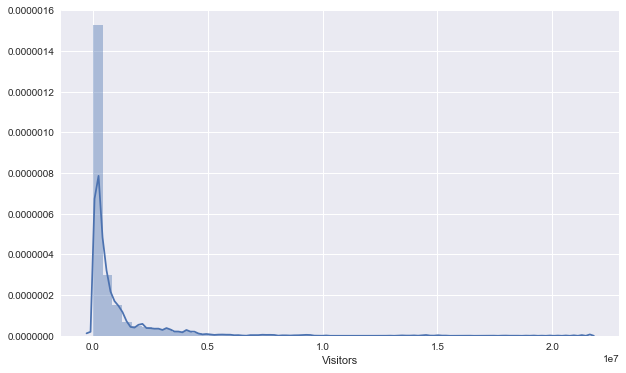

In [27]:
sns.set(rc={"figure.figsize": (10, 6)})
fig = plt.figure()
sns.distplot(train['Visitors'])

Из графика выше видно, что распределение совсем не похоже на нормальное. Чтобы убедиться в этом, добавим нормальное распределение (из scipy) к графику и сравним его с распределением целевой переменной.

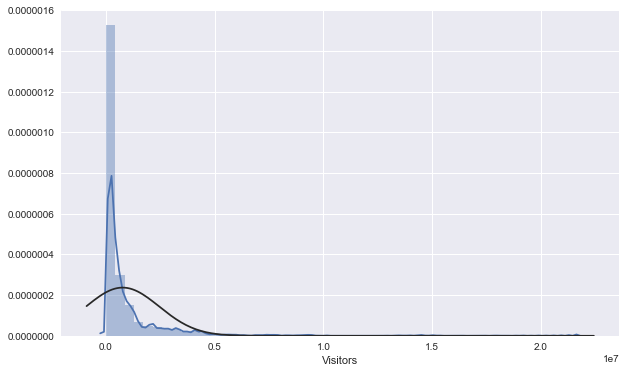

In [28]:
sns.set(rc={"figure.figsize": (10, 6)})
fig = plt.figure()
sns.distplot(train['Visitors'], fit=stats.norm)

Распределение целевой переменной скошенно и сильно отличается от нормального. Проведем стат.тесты.

In [29]:
print("Скошенность: %f" % stats.skew(train['Visitors']))
print("Эксцесс: %f" % stats.kurtosis(train['Visitors']))

Скошенность: 5.393353
Эксцесс: 40.071283


In [30]:
stats.normaltest(df['Visitors'].values)

NormaltestResult(statistic=6483.6642043916145, pvalue=0.0)

Как видим, скошенность и эксцесс распределения очень большие. В дальнейшем нам будет необходимо преобразовать целевую переменную и попытаться сделать распределение близким к нормальному.

#### Вещественные признаки

Рассмотрим вещественный признаки.

In [31]:
train.describe()

,Visitors,Year,PRIM_LAT_DEC,PRIM_LONG_DEC
count,5.795000e+03,5795.000000,5795.000000,5795.000000
mean,7.648219e+05,2007.609146,38.998598,-96.971976
std,1.684387e+06,4.603051,8.498906,26.095881
min,0.000000e+00,2000.000000,-14.236873,-169.452789
25%,4.847750e+04,2004.000000,35.168228,-111.113563
50%,1.922100e+05,2008.000000,38.684757,-91.578484
75%,6.885270e+05,2012.000000,41.856343,-77.436945
max,2.153876e+07,2015.000000,68.004212,144.655114


В датасете всего три вещественных признака, построим графики, чтобы найти какие-нибудь закономерности или зависимости.

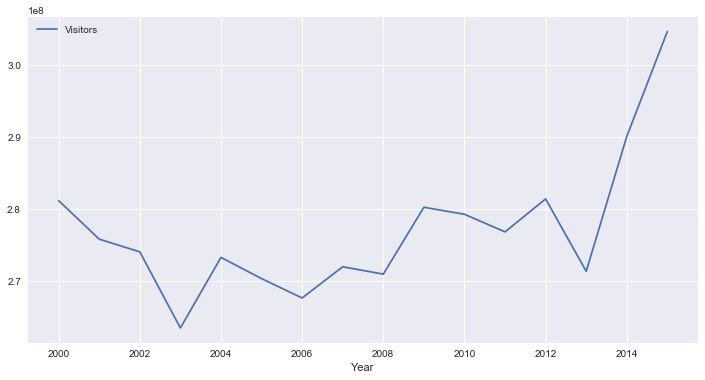

In [32]:
visitors_df = train[['Visitors'] + ['Year']]
visitors_df.groupby('Year').sum().plot(figsize=(12,6))

Шкала графика выше вводит заблуждение, на самом деле количество посетителей меняется не так сильно от года в год. Чтобы убедиться в этом, посмотрим на bar-chart.

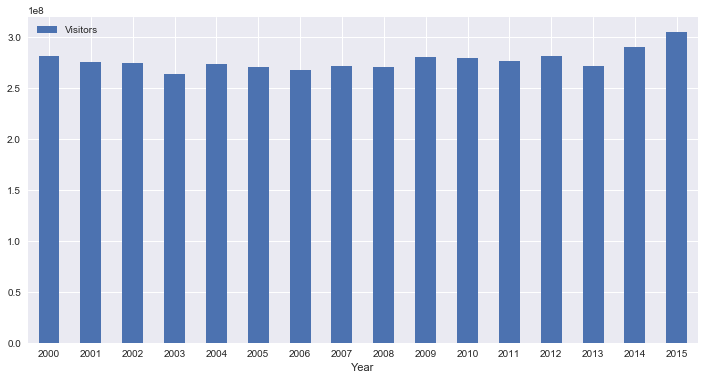

In [33]:
visitors_df.groupby('Year').sum().plot(kind='bar', rot=0,figsize=(12,6))

Что и требовалось доказать. Тем не менее, число посителей все же выросло в 2015 году. Теперь посмотрим на корреляции между веществеными признаками и целевой переменной.

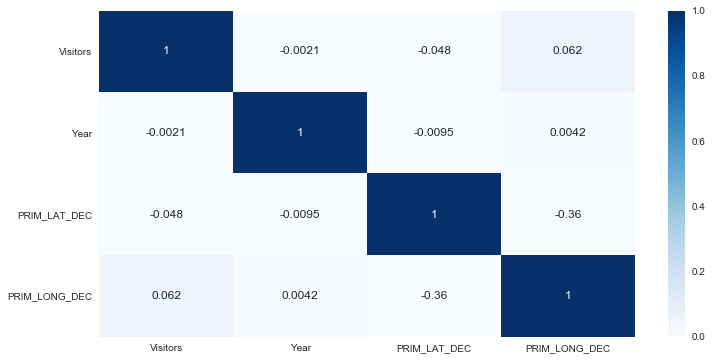

In [34]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.heatmap(train.corr(), vmin=0, vmax=1,annot=True, cmap="Blues")
plt.show()

Как видно из графика, корреляция между вещественными признаками и целевой переменной достаточно слабая.

Изучим датасет на выбросы. Для этого построим пару графиков и попытаемся найти и интерпретировать выбросы.

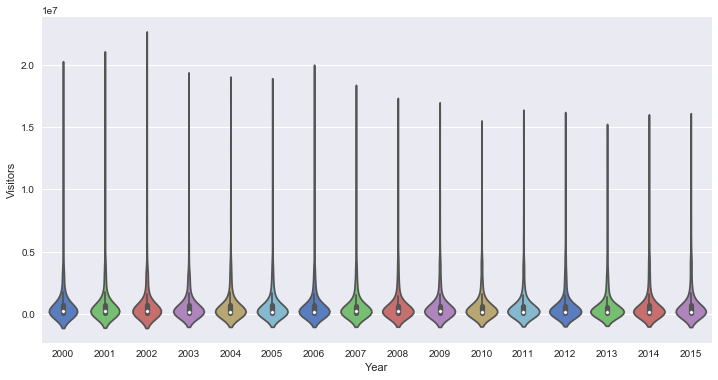

In [35]:
sns.set(rc={"figure.figsize": (12, 6)})
sns.violinplot(x='Year', y="Visitors", data=train, palette="muted", split=True)

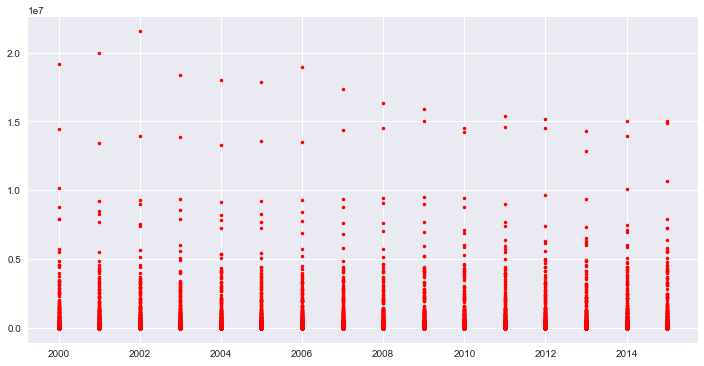

In [36]:
sns.set(rc={"figure.figsize": (12, 6)})
plt.plot(train['Year'], train['Visitors'], 'r.')
plt.show()

Графики выше показывают, что у датасета есть выбросы, но необходимо изучить природу таких больших значений.

In [37]:
train.sort_values(by='Visitors', ascending=False).head(5)

,Gnis Id,Parkname,Region,State,Unit Code,Unit Name,Unit Type,Visitors,Year,PRIM_LAT_DEC,PRIM_LONG_DEC
5923,1009494,Unknown,NT,NC,BLRI,Blue Ridge Parkway,Parkway,21538760,2002,36.436499,-81.070565
6274,1009494,Unknown,NT,NC,BLRI,Blue Ridge Parkway,Parkway,19969587,2001,36.436499,-81.070565
6624,1009494,Unknown,NT,NC,BLRI,Blue Ridge Parkway,Parkway,19153081,2000,36.436499,-81.070565
4487,1009494,Unknown,NT,NC,BLRI,Blue Ridge Parkway,Parkway,18953478,2006,36.436499,-81.070565
5570,1009494,Unknown,NT,NC,BLRI,Blue Ridge Parkway,Parkway,18344051,2003,36.436499,-81.070565


Самое большое количество посещений на протяжении всего периода 2000-2015 у Parkway, что вполне логично. Таким образом, большие значения объясняются природой данных.

Посмотрим на другие достопримечательности, которые собирают большое количество посетителей.

In [38]:
pd.unique(train['Unit Name'].loc[(train['Visitors'] >= 5000000) & (train['Unit Name'] != 'Blue Ridge Parkway')])

array(['World War II Memorial', 'Great Smoky Mountains National Park',
       'George Washington Memorial Parkway', 'Vietnam Veterans Memorial',
       'Lincoln Memorial', 'Grand Canyon National Park',
       'Lake Mead National Recreation Area',
       'Golden Gate National Recreation Area',
       'Gateway National Recreation Area', 'Natchez Trace Parkway',
       'Chesapeake and Ohio Canal National Historical Park',
       'Gulf Islands National Seashore',
       'Delaware Water Gap National Recreation Area',
       'Statue Of Liberty National Monument'], dtype=object)

Названия объектов говорят сами за себя, они действительно набирают миллионы посетителей каждый год, поэтому причина больших значений вполне объяснима - природа данных.

#### Категориальные признаки

В датасете 6 категориальных признаков. Один Parkname из них имеет пропуски, и кроме того, полные названия объектов представлены в признаке Unit Name. Таким образом, предлагается удалить этот признак. 

In [39]:
train.drop(['Parkname'], axis=1, inplace=True)
test.drop(['Parkname'], axis=1, inplace=True)

Теперь у нас 5 категориальных признаком. Посмотрим на количество уникальных категорий в каждом из них.

In [40]:
print(len(pd.unique(df['Region'])))
print(len(pd.unique(df['State'])))
print(len(pd.unique(df['Unit Code'])))
print(len(pd.unique(df['Unit Name'])))
print(len(pd.unique(df['Unit Type'])))

8
54
371
379
28


Предлагается, каждый такой признак преобразовать с помощью One-Hot кодирования.

###  Часть 4. Закономерности, "инсайты", особенности данных

- В датасете есть пропуски - все они были решены
- В датасете были обнаружены ошибки, допущенные в ходе сбора данных - все они были также решены
- В датасете были выявлены выбросы, которые объясняются природой данных
- Распределение целевой переменной не нормальное - преобразуем его в части Предобработка данных
- Между целевой переменной и другими вещественными признаками была выявлена слабая корреляция. Таким образом, при построении модели будем делать акцент на категориальные признаки
- В датасете 5 категориальных признаков, предалагется преобразовать их с помощью One-Hot Encoding

###  Часть 5-6. Выбор метрики и модели

В качестве метрики будем использовать r2_score (r_squared) - коэффициент детерминации. Под данной метрикой подразумевают долю дисперсии зависимой переменной, которая объясняется рассматриваемой моделью зависимости, то есть объясняющими переменными (признаками). 
Выбор обусловлен:
- задачей регресии, т.к. данная метрика является универсальной мерой и идеально подходит для данной задачи
- спецификой и особенностями данных

В качестве модели будем использовать:
- Ridge, т.к. одна из универсальных простых линейных моделей, необходимых для восстановления регрессии
- CatBoostRegressor, т.к. данный датасет включает в себя большое количество категориальных признаков, с которыми CatBoost хорошо справляется

###  Часть 7-8. Предобработка данных и создание новых признаков

Некоторые признаки мы уже предобработали ранее. Далее предлагается удалить ненужный признак GNIS ID, т.к. сам по себе он не несет никакой информации, необходимой для модели, но с помощью него мы уже достали широту и долготу.

In [41]:
train.drop(['Gnis Id'], axis=1, inplace=True)
test.drop(['Gnis Id'], axis=1, inplace=True)

#### Целевой признак

Как было отмечено ранее, распределение целевой переменной не прошло тест на нормальность. Поэтому необходимо попытаться сделать его близким к нормальному. Рассмотрим два метотда: логарифмирование и метод [Бокса-Кокса](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%91%D0%BE%D0%BA%D1%81%D0%B0-%D0%9A%D0%BE%D0%BA%D1%81%D0%B0)

Сначала применим первый метод - логарифмирование.

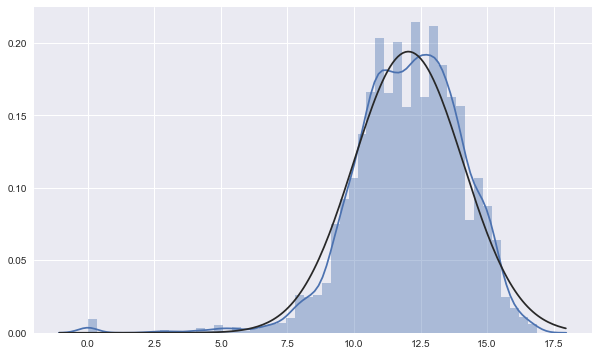

In [42]:
sns.set(rc={"figure.figsize": (10, 6)})
fig = plt.figure()
sns.distplot(np.log1p((df['Visitors'].values)), fit=stats.norm)

In [43]:
print("Скошенность: %f" % stats.skew(np.log1p((df['Visitors'].values))))
print("Эксцесс: %f" % stats.kurtosis(np.log1p((df['Visitors'].values))))

Скошенность: -0.994030
Эксцесс: 3.823419


In [44]:
stats.normaltest(np.log1p((df['Visitors'].values)))

NormaltestResult(statistic=1274.7241952395866, pvalue=1.5745557036437986e-277)

Как видно из результатов теста на нормальность и графика, нам удалось сделать распределение более нормальным, но все еще присутствует скошенность и эксцесс. Применим второй метод - меттод Бокса-Кокса.

In [45]:
# добавим единицу к посетителям, т.к. для данного метода значения должны быть строго больше нуля 
stats.boxcox(df['Visitors'].values+1)

(array([21.64911594, 19.43188089, 17.22290007, ..., 26.77411443,
        28.65909602, 23.88624452]), 0.10030711941693501)

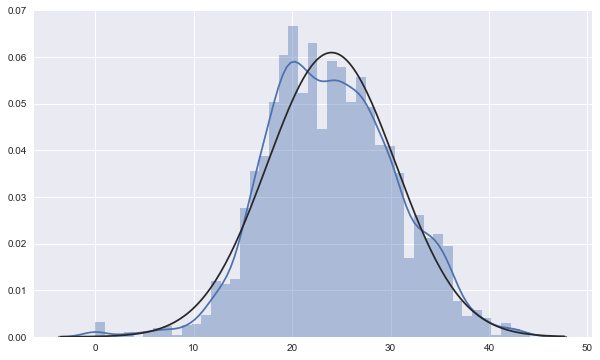

In [46]:
sns.set(rc={"figure.figsize": (10, 6)})
fig = plt.figure()
sns.distplot(stats.boxcox(train['Visitors'].values+1)[0], fit=stats.norm)

In [47]:
stats.normaltest(stats.boxcox(train['Visitors'].values+1)[0])

NormaltestResult(statistic=10.608746455401471, pvalue=0.00496981219307766)

In [48]:
print("Скошенность: %f" % stats.skew(stats.boxcox(train['Visitors'].values+1)[0]))
print("Эксцесс: %f" % stats.kurtosis(stats.boxcox(train['Visitors'].values+1)[0]))

Скошенность: 0.028024
Эксцесс: 0.219869


В данном случае, метод Бокса-Кокса был более эффективен, поэтому преобразуем нашу целевую переменную с помощью этого метода. Также отделим целевую переменную от других признаков.

In [49]:
X_train, y_train = train.drop('Visitors', axis=1).values, stats.boxcox(train['Visitors'].values+1)[0]
X_test, y_test = test.drop('Visitors', axis=1).values, stats.boxcox(test['Visitors'].values+1)[0]

####  OHE для категориальных признаков 

Будем использовать готовые выборки (X_train, X_test) для CatBoostRegressor, т.к. он сам преобразует категориальные признаки. Для Ridge преобразуем категориальные признаки с помощью One-Hot Encoding. Напишем функцию для преобразования, а затем применим ее ко всем категоримальным признакам.

In [50]:
def ohe_encoder(column,dftype):
    enc = OneHotEncoder(sparse=False)
    label_encoder = LabelEncoder()


    values = np.array(df['{}'.format(column)].values)
    values_labeled = label_encoder.fit_transform(values)

    enc.fit(values_labeled.reshape(len(values_labeled), 1))

    if dftype == 'train':
        df_labeled = label_encoder.transform(train['{}'.format(column)])
    else:
        df_labeled = label_encoder.transform(test['{}'.format(column)])
    
    
    df_encoded = enc.transform(df_labeled.reshape(len(df_labeled), 1))
    
    return df_encoded

In [51]:
%%time
train_region_ohe = ohe_encoder(column='Region',dftype = 'train')
train_state_ohe = ohe_encoder(column='State',dftype = 'train')
train_ucode_ohe = ohe_encoder(column='Unit Code',dftype = 'train')
train_uname_ohe = ohe_encoder(column='Unit Name',dftype = 'train')
train_utype_ohe = ohe_encoder(column='Unit Type',dftype = 'train')

CPU times: user 107 ms, sys: 40.9 ms, total: 148 ms
Wall time: 147 ms


In [52]:
%%time
test_region_ohe = ohe_encoder(column='Region',dftype = 'test')
test_state_ohe = ohe_encoder(column='State',dftype = 'test')
test_ucode_ohe = ohe_encoder(column='Unit Code',dftype = 'test')
test_uname_ohe = ohe_encoder(column='Unit Name',dftype = 'test')
test_utype_ohe = ohe_encoder(column='Unit Type',dftype = 'test')

CPU times: user 53.3 ms, sys: 18.1 ms, total: 71.3 ms
Wall time: 69.5 ms


Соединим все полученные признаки в два датасета train_stacked и test_stacked.

In [53]:
train_stacked = np.hstack([train_region_ohe,train_state_ohe,
                           train_ucode_ohe,train_uname_ohe,
                           train_utype_ohe,
                           train[['Year', 'PRIM_LAT_DEC','PRIM_LONG_DEC']].values])
test_stacked = np.hstack([test_region_ohe,test_state_ohe,
                           test_ucode_ohe,test_uname_ohe,
                           test_utype_ohe,
                           test[['Year', 'PRIM_LAT_DEC','PRIM_LONG_DEC']].values])

###  Часть 9. Кросс-валидация, подбор параметров

#### Ridge Regression

Для Ridge укажем различные значения для основного параметра alpha - порога регуляризации. Чем выше значение, тем сильнее регуляризация.
Далее обучим GridSearchCV для выявления лучших параметров.

In [54]:
params = {'alpha' : [1,0.1,1e2,1e3,1e4]}

In [55]:
%%time
linreg = Ridge()
kf = KFold(n_splits=3, shuffle=True, random_state=17)
linreg_cv = GridSearchCV(linreg, param_grid=params, scoring='r2', cv=kf)
linreg_cv.fit(train_stacked, y_train)

CPU times: user 5.25 s, sys: 572 ms, total: 5.83 s
Wall time: 2.88 s


In [56]:
print('Best parameters for Ridge: ', linreg_cv.best_params_)
print('R2 score for Ridge: ', round(linreg_cv.best_score_, 5))

Best parameters for Ridge:  {'alpha': 0.1}
R2 score for Ridge:  0.95302


GridSearchCV показал лучшее значение порога регуляризации 0.1, его и будем использовать на тестовой выборке.

#### CatBoostRegressor

Для CatBoostRegressor явно укажем какие из признаков являются категориальными (features). Кроме того, зададим различные значения для глубины дерева (depths) и количества итераций (iterations).

In [57]:
features = [0,1,2,3,4]
depths = [7,8,9,10]
iterations = [250,300]

Напишем собственную кастомную версию кросс-валидации для CatBoost и сравним резльтуты различных комбинаций параметров.

In [59]:
counter = 1
for x in depths:
    for y in iterations:
        print('Starting  '+ str(counter) + ' training: depth - ' + str(x) + ', iterations - ' + str(y))
        kf = KFold(n_splits=3,shuffle=True,random_state=17)
        results = 0
        fold = 1
        for train_index, test_index in kf.split(X_train):
            cat_train, cat_test = X_train[train_index], X_train[test_index]
            train_labels, test_labels = y_train[train_index], y_train[test_index]


            cat = CatBoostRegressor(depth=x,iterations=y,random_seed=17,logging_level='Silent')
            cat.fit(cat_train, train_labels, cat_features=features)
            cat_pred = cat.predict(cat_test)
            
            results += r2_score(test_labels, cat_pred)
            print(fold, 'fold score is: ', r2_score(test_labels, cat_pred))
            fold += 1
        
        print('Average score for',str(counter),'training is:',results/3)
        print('Done...' + '\n')
        counter += 1

Starting  1 training: depth - 7, iterations - 250
1 fold score is:  0.8009938507549684
2 fold score is:  0.7924750944218538
3 fold score is:  0.7937114042105635
Average score for 1 training is: 0.7957267831291285
Done...

Starting  2 training: depth - 7, iterations - 300
1 fold score is:  0.8229480853664957
2 fold score is:  0.8040085300003805
3 fold score is:  0.8019022815432796
Average score for 2 training is: 0.8096196323033853
Done...

Starting  3 training: depth - 8, iterations - 250
1 fold score is:  0.806931231762744
2 fold score is:  0.7918703657393145
3 fold score is:  0.805451958142545
Average score for 3 training is: 0.8014178518815345
Done...

Starting  4 training: depth - 8, iterations - 300
1 fold score is:  0.8205620909099582
2 fold score is:  0.7999209194789851
3 fold score is:  0.8134460473465592
Average score for 4 training is: 0.8113096859118342
Done...

Starting  5 training: depth - 9, iterations - 250
1 fold score is:  0.8088629454366342
2 fold score is:  0.7957526

Лучший резлуьтат (0.8170822248344393) на кросс-валидации показала модель с параметрами depth - 10, iterations - 300. Именно их будем использовать на тестовой выборке.

### Часть 10. Построение кривых валидации и обучения

Построим кривые валидации для Ridge.

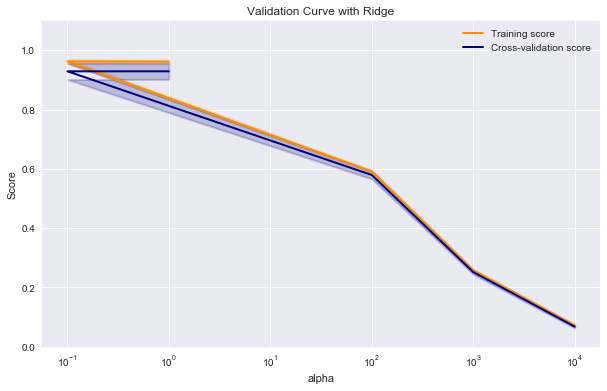

In [60]:
plt.figure(figsize=(10,6))
param_range = [1,0.1,1e2,1e3,1e4]
train_scores, test_scores = validation_curve(
    Ridge(), train_stacked, y_train, param_name='alpha', param_range=param_range,
    cv=3, scoring="r2")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with Ridge")
plt.xlabel("alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Как мы видим из графика, кривые валидации с увеличением порога регуляризации alpha немного расходятся (справа-налево), это означает, что с увеличением alpha может наблюдаться переобучение. Теперь построим кривые обучения для Ridge.

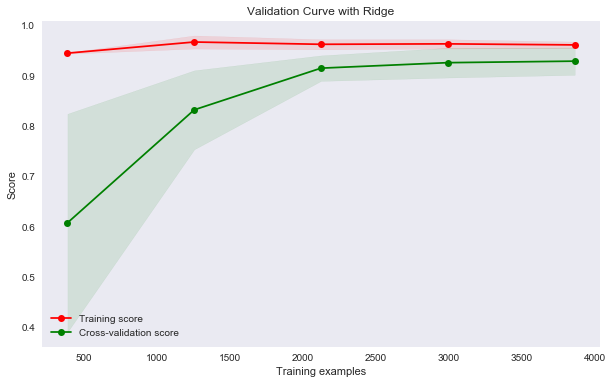

In [61]:
plt.figure(figsize=(10,6))

train_sizes, train_scores, test_scores = learning_curve(
        Ridge(), train_stacked, y_train, cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")


plt.title("Validation Curve with Ridge")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")


plt.show()

На графике видно, что с увеличением количества примеров. качества на валидации улучшается. Т.к. кривые обучения не сблизились в самом конце, необходимо добавить больше примеров обуччающей выборки.

###  Часть 11. Прогноз для тестовой выборки и Оценка модели с описанием выбранной метрики

Теперь, когда у нас есть лучшие параметры, мы готовы обучить модели на тестовой выборке, т.е. предсказать количество посетителей национальных достопримечательностей США.

#### Ridge

In [62]:
%%time
ridge = Ridge(alpha=0.1)
ridge.fit(train_stacked, y_train)
ridge_pred = ridge.predict(test_stacked)

CPU times: user 466 ms, sys: 72.7 ms, total: 538 ms
Wall time: 374 ms


In [63]:
r2_score(y_test, ridge_pred)

0.8711647097580936

Коэффициент детерминации достаточно высокий но сильно отличается от результата, показанного на кросс-валидации (0.95302).

#### CatBoostRegressor

In [64]:
%%time
cat = CatBoostRegressor(depth=10, iterations=300,eval_metric='R2',logging_level='Silent')
cat.fit(X_train, y_train, cat_features=features)
cat_pred = cat.predict(X_test)

CPU times: user 28.9 s, sys: 1.53 s, total: 30.4 s
Wall time: 8.96 s


In [65]:
r2_score(y_test, cat_pred)

0.7529929633300172

CatBoostRegressor показал себя хуже на тестовой выборке (0.7529929633300172), чем лучшая модель на валидации (0.8170822248344393). Вполне вероятно, что виной такой разницы может быть переобучение.

### Часть 12. Выводы 

В результате исследования, были построены две модели Ridge из sklearn и CatBoostRegressor из CatBoost.
На тестовой выборке CatBoostRegressor (0.7529929633300172) показал результат хуже, чем Ridge (0.8711647097580936). Обе модели переобучаются. Если Ridge переобучается из-за высокого порога alpha, то для выяснения причин переобучения CatBoostRegressor потребуется более детальное исследование.
Кривые обучения также показали, что необходимо добавить больше примеров для обучающей выборки.

Предполагаемые улучшения:
1. Избавление от переобучения
2. Создание новых признаков из текущего датасета + можно привлечь сторонние дополнительные данные
3. Тюнинг параметров, т.к. были расмотренны только основные параметры моделей.
